In [ ]:
!pip install pydotplus

In [2]:
!pip install numpy pandas scikit-learn xgboost graphviz matplotlib torch


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     ------------------------------------- 167.0/167.0 kB 10.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ---------------------------------------- 59.7/59.7 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 15.9 MB/s eta 0:00:01
   --- ------------------------------------ 1.1/11.0 MB 13.5 MB/s eta 0:00:01
   ----- ---------------------------------- 1.6/11.0 MB 12.6 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.0 MB 12.3 MB/s eta 0:00:01
   --------- ------------------------------ 2.7/11.0 MB 12.1 MB/s eta 0:00:01
   ----------- ---------------------------- 3.2/11.0 MB 12.1 MB/s eta 0:00:01
   --------

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import graphviz
import pydotplus

import joblib

from sklearn import linear_model, tree, ensemble, model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

import xgboost

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:{}".format(device))
data_path = './Loan_Default.csv'
# 제거 항목 'ID', 'year', 'Gender'
feature_name = ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial',
                'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
                'lump_sum_payment', 'property_value', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
                'Credit_Score', 'co-applicant_credit_type', 'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status', 'dtir1']

test_data_ratio = 0.3
random_state = 0

max_depth = 5
min_sample_leaf = 3

num_binomial_class = 2   # 결과는 상환 했다 안 했다 2개

learning_rate = 5e-3    # 한번 학습을 시키는데 적용하는 정도
epochs = 200          # 전체 데이터를 몇 번 모델에게 보여주며 할 것인가

criterion = nn.CrossEntropyLoss()

missing_value_flag = 'replace'  # 결측치는 대체값으로

num_sample = 10

eda_df = pd.read_csv(data_path) # 데이터 불러오기
eda_df.head(num_sample) # 개수만큼 상위 데이터 출력


ModuleNotFoundError: No module named 'torch'

# Data Load

- ID: 데이터 또는 대출 신청의 고유 식별자.
- year: 대출 신청이 이루어진 연도.
- loan_limit: 대출 한도에 대한 정보. 대출 한도가 있는지 없는지?
- Gender: 성별. 값은 'Male', 'Female', 'Sex Not Available' 'Joint'
- approv_in_adv: 대출이 사전 승인되었는지 여부
- loan_type: 대출의 유형. 'type1', 'type2' 등으로 대출 상품 종류를 구분.
- loan_purpose: 대출 목적
- Credit_Worthiness: 신용할 수 있는 상태? 신용 등급, 대출자가 채무 불이행 가능성을 판단하는 방법 또는 신규 신용을 받을 자격이 있는지 여부
- open_credit: 신청자가 다른 개설된 신용 계좌를 가지고 있는지 여부.
- business_or_commercial: 대출이 비즈니스 또는 상업용인지 여부. 대출 금액의 사용 목적
- loan_amount: 정확한 대출 금액
- rate_of_interest: 대출자가 차용인에게 부과하는 금액으로, 대출 원금의 백분율. 이자율?
- Interest_rate_spread: 금융 기관이 예금자에게 지불하는 이자율과 대출에서 받는 이자율의 차이. 기준 이자율 대비 가산 이자율. 기준 지수 대비 이자율 차이.
- Upfront_charges: 신규 대출에 대한 대가로 차용인이 대출자에게 지불하는 수수료. 선불 수수료. 대출 초기 수수료.
- term: 대출 기간. 대출 상환 기간.
- Neg_ammortization: 부정 상환(역상각, 초기 이자를 적게하고 이를 후에 추가해 원금이 증가하는 상환 방식) 여부. 대출 차용인이 은행이 정한 표준 할부금보다 적은 금액을 지불하는 상황
- interest_only: 거치 기간(이자만 상환하는 기간) 여부. 'not_int'는 이자만 상환하는 기간이 없음을 의미.
- lump_sum_payment: 일시불 지불 옵션이 있는지 여부. 만기 일시상환 여부. 'not_lpsm'은 만기 일시상환이 아님.
- property_value: 담보의 가치. 대출과 연계된 자산의 가치.
- construction_type: 자산의 건축 유형. 건설 유형.
- occupancy_type: 자산의 점유 형태. 'pr'은 거주용(primary residence)을 의미.
- Secured_by: 대출보증, 담보 유형입니다. 'home'은 주택 담보를 의미.
- total_units: 대출과 관련된 유닛 수. 부동산의 총 단위 수입니다. '1U'는 단독 주택 또는 1가구 주택을 의미.
- income: 대출 신청자의 소득.
- credit_type: 사용된 신용 조회 유형. 신용 평가 기관.
- Credit_Score: 신용 점수.
- co-applicant_credit_type: 공동 신청자의 신용 조회 유형. 공동 신청자의 신용 평가 기관.
- age: 신청자의 연령대.
- submission_of_application: 신청서 제출 방식. 'to_inst'는 기관을 통해 제출했음을 의미.
- LTV: 대출 금액 대비 자산 가치의 비율. 담보인정비율(Loan to Value)로, 대출 금액을 담보 가치로 나눈 백분율.
- Region: 대출 신청 지역.
- Security_Type: 담보의 유형.
- Status: 채무 불이행 여부. (Lable column)
- dtir1:총 부채 상환 비율(Debt to Income Ratio). 이는 소득 대비 부채의 비율을 나타냄.

참고 : https://www.kaggle.com/code/claudiojnior/98-accuracy-eda-ml-algorithms-model-fine-tune

In [5]:
print ('# of data: {row}\n# of feature: {col}\n'.format(row = eda_df.shape[0], col = eda_df.shape[1]))

print('feature name/dtype')
numerical_count = 0             # 숫자형 feature의 개수를 셀 변수
categorical_count = 0          # 숫자형이 아닌 feature의 개수를 셀 변수

for feature_name, feature_type in zip(eda_df.columns, eda_df.dtypes):
    # 숫자형 자료형인지 확인
    if np.issubdtype(feature_type, np.number):      # isuubdtype(dtype,upperdtype) 자료형 dtype이 upperdatatyep의 하위 자료형이면 True, 아니면 False
        numerical_count += 1
    else:
        categorical_count += 1
    print('{} : {}'.format(feature_name, feature_type))

print('\n # of numerical item: {}/# of categorical item: {}'.format(numerical_count, categorical_count))

print('\nstatistcal infos')
print(eda_df.describe(include='all'))       # feature 별로 통계정보들을 표로 정리해줌

# of data: 148670
# of feature: 34

feature name/dtype
ID : int64
year : int64
loan_limit : object
Gender : object
approv_in_adv : object
loan_type : object
loan_purpose : object
Credit_Worthiness : object
open_credit : object
business_or_commercial : object
loan_amount : int64
rate_of_interest : float64
Interest_rate_spread : float64
Upfront_charges : float64
term : float64
Neg_ammortization : object
interest_only : object
lump_sum_payment : object
property_value : float64
construction_type : object
occupancy_type : object
Secured_by : object
total_units : object
income : float64
credit_type : object
Credit_Score : int64
co-applicant_credit_type : object
age : object
submission_of_application : object
LTV : float64
Region : object
Security_Type : object
Status : int64
dtir1 : float64

 # of numerical item: 13/# of categorical item: 21

statistcal infos
                   ID      year loan_limit  Gender approv_in_adv loan_type  \
count   148670.000000  148670.0     145326  148670      

In [6]:
# feature와 label 분리
label_df = eda_df['Status']                 # 정답 정보 feature
eda_df = eda_df.drop(columns=['ID', 'year', 'Status'])      #.3
label_dict = label_df.value_counts()    # 정답 정보의 정리

print('label shape: {}'.format(label_df.shape))

print('\nnum of negative label: {} / num of positive label: {}'.format(label_dict[0], label_dict[1])) # 0의 발생 횟수와 1의 발생횟수 count
print('% of negative label: {} / % of positive label: {}'.format(label_dict[0] / label_df.shape[0] * 100, label_dict[1] / label_df.shape[0] * 100)) # 퍼센테이지로 나타낸다.
print('sum:{}\n'.format(sum(label_df.to_numpy())))
# 데이터 전처리
print('\nStart Removing Duplicates') # 중복치 제거 실시
duplicates = eda_df.duplicated()
beforLen = len(eda_df)
eda_df = eda_df[~duplicates]
label_df = label_df[~duplicates]
afterLen = len(eda_df)

print('Delect {} duplicate data'.format(beforLen - afterLen))
# 결측치 처리
print('\nStart Handling Missing Values')
print('features / # of missing values\n')
print(eda_df.isnull().sum())

if missing_value_flag == 'remove':
    print('Remove missing values\n')
    non_missing = ~eda_df.isnull().any(axis=1)
    missing_rows = eda_df[eda_df.isnull().any(axis=1)]
    # 'status' 컬럼 값 출력
    del_index = missing_rows.index

    deleted_label_values = label_df.iloc[del_index].sum()

    print("삭제되는 인덱스에 해당하는 label_df의 값들:\n", deleted_label_values)

    print("삭제되는 행의 개수: {}".format(len(eda_df) - non_missing.sum()))
    eda_df = eda_df[non_missing]
    label_df = label_df[non_missing]
    # remove를 하면 status가 1인 값들은 전부 삭제 된다

elif missing_value_flag == 'replace':
    print('Replace missing values with mean\n')
    for feature_name in eda_df.columns:
        if eda_df[feature_name].dtype in ['int32', 'int64', 'float32', 'float64']:
            if eda_df[feature_name].isnull().sum() > 0:                                   # 결측치가 1개 이상이면
                eda_df[feature_name].fillna(eda_df[feature_name].mean(), inplace=True)    # 컬럼의 평균값을 넣는다 eda_df[feature_name].mean() -> 평균, inplace=True 원본 데이터프레임에 직접 적용
        else:
            if eda_df[feature_name].isnull().sum() > 0:                                   # 결측치가 1개 이상이면
                mode_value = eda_df[feature_name].mode()[0]                               # 최빈값으로 넣는다.
                eda_df[feature_name].fillna(mode_value, inplace=True)


print('sum:{}\n'.format(sum(label_df.to_numpy())))

label shape: (148670,)

num of negative label: 112031 / num of positive label: 36639
% of negative label: 75.3554853030201 / % of positive label: 24.64451469697989
sum:36639


Start Removing Duplicates
Delect 0 duplicate data

Start Handling Missing Values
features / # of missing values

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units

<ipython-input-6-3253352ca89b>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_df[feature_name].fillna(mode_value, inplace=True)
<ipython-input-6-3253352ca89b>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

sum:36639



In [7]:
class LoanClassificationDataLoad:
    def __init__(self, path, feature_names, test_data_ratio, random_state, feature_data, label_data, imbalance_flag):
        self.data_path = path
        self.feature_names = feature_names
        self.test_data_ratio = test_data_ratio
        self.random_state = random_state

        self.feature_data = feature_data.copy()
        self.label_data = label_data.copy()



        self.imbalance_feate_data, self.imbalance_labe_data = self.get_imbalance_dataset()

        if imbalance_flag == True:
            self.train_data, self.test_data, self.train_label, self.test_label = train_test_split(self.imbalance_feate_data, self.imbalance_labe_data, test_size=self.test_data_ratio, random_state=self.random_state)
        else:
            self.train_data, self.test_data, self.train_label, self.test_label = train_test_split(self.feature_data, self.label_data, test_size=self.test_data_ratio, random_state=self.random_state)



        print('train data shape: {}/label shape: {}'.format(self.train_data.shape, self.train_label.shape))
        print('test data shape: {}/label shape: {}'.format(self.test_data.shape, self.test_label.shape))

        self.train_numerical_features = self.train_data.select_dtypes(include=[np.number])
        self.train_numerical_array = self.train_numerical_features.values
        self.test_numerical_features = self.test_data.select_dtypes(include=[np.number])
        self.test_numerical_array = self.test_numerical_features.values

        self.train_categorical_features = self.train_data.select_dtypes(include=[object])
        self.test_categorical_features = self.test_data.select_dtypes(include=[object])

        self.min_max_normalize_data()
        self.standardize_data()

        self.encoding_ont_hot()

        print('numerical feature count: {}'.format(self.train_numerical_array.shape[1]))
        print('categorical feature count: {}'.format(len(self.train_categorical_features.columns)+1))
        print('encoded feature count: {}'.format(sum(self.train_encoded_feature_count_list)))



        self.train_encoded_array = np.hstack(self.train_one_hot_encoded_list)
        self.test_encoded_array = np.hstack(self.test_one_hot_encoded_list)

        self.train_encoded_array = np.hstack(self.train_one_hot_encoded_list)
        self.test_encoded_array = np.hstack(self.test_one_hot_encoded_list)

        self.min_max_train_processed_array = np.hstack((self.scaled_min_max_train_data, self.train_encoded_array))
        self.standardize_train_processed_array = np.hstack((self.scaled_standardize_train_data, self.train_encoded_array))

        self.min_max_test_processed_array = np.hstack((self.scaled_min_max_test_data, self.test_encoded_array))
        self.standardize_test_processed_array = np.hstack((self.scaled_standardize_test_data, self.test_encoded_array))


        self.test_label_array = self.test_label.to_numpy()
        self.train_label_array = self.train_label.to_numpy()

        print('processed min-max train data array shape: {} / label shape: {}'.format(self.min_max_train_processed_array.shape, self.train_label_array.shape))
        print('processed standardize train data array shape: {} / label shape: {}'.format(self.standardize_train_processed_array.shape, self.train_label_array.shape))

        print('processed min-max test data array shape: {}/label shape: {}'.format(self.min_max_test_processed_array.shape, self.test_label_array.shape))
        print('processed standardize test data array shape: {}/label shape: {}'.format(self.standardize_test_processed_array.shape, self.test_label_array.shape))
        #self.show_label_dict()

    def get_imbalance_dataset(self):
        positive_indices = np.where(self.label_data == 1)[0]
        positive_indices = np.random.choice(positive_indices, size=int(len(positive_indices)/10), replace=False)
        negative_indices = np.where(self.label_data == 0)[0]

        selected_indices = np.concatenate((positive_indices, negative_indices))

        print('self.feature_data type:{}, self.label_data type:{}, pos:{}, neg:{}, sel:{}'.format(type(self.feature_data), type(self.label_data), type(positive_indices), type(negative_indices), type(selected_indices)))

        return self.feature_data.iloc[selected_indices], self.label_data.iloc[selected_indices]

    def __call__(self, flag, scaling_flag):
        if flag == 'train':
            if scaling_flag == 'min-max':
                return self.min_max_train_processed_array, self.train_label_array
            elif scaling_flag == 'standardize':
                return self.standardize_train_processed_array, self.train_label_array
        elif flag == 'test':
            if scaling_flag == 'min-max':
                return self.min_max_test_processed_array, self.test_label_array
            elif scaling_flag == 'standardize':
                return self.standardize_test_processed_array, self.test_label_array

    # min-max
    def min_max_normalize_data(self):
        min_values = np.min(self.train_numerical_array, axis=0)
        max_values = np.max(self.train_numerical_array, axis=0)

        max_values = np.where(max_values == min_values, min_values + 1e-5, max_values)

        self.scaled_min_max_train_data = (self.train_numerical_array - min_values) / (max_values - min_values)
        self.scaled_min_max_test_data = (self.test_numerical_array - min_values) / (max_values - min_values)

    # standardize
    def standardize_data(self):
        mean = np.mean(self.train_numerical_array, axis=0)
        std = np.std(self.train_numerical_array, axis=0)

        std = np.where(std == 0, 1e-5, std)

        self.scaled_standardize_train_data = (self.train_numerical_array - mean) / std
        self.scaled_standardize_test_data = (self.test_numerical_array - mean) / std

    def encoding_ont_hot(self):
        self.train_one_hot_encoded_list = []
        self.test_one_hot_encoded_list = []

        self.train_encoded_feature_count_list = []
        print('One-hot encoding of categorical features\n')
        for feature_name in self.train_categorical_features.columns:
            unique_values = np.unique(self.train_categorical_features[feature_name])
            self.train_encoded_feature_count_list.append(len(unique_values)+1)

            self.train_encoded_array = np.zeros((self.train_categorical_features.shape[0], len(unique_values) + 1))
            for index, value in enumerate(self.train_categorical_features[feature_name]):
                self.train_encoded_array[index, np.where(unique_values == value)[0]] = 1
            self.train_one_hot_encoded_list.append(self.train_encoded_array)

            self.test_encoded_array = np.zeros((self.test_categorical_features.shape[0], len(unique_values) + 1))
            for index, value in enumerate(self.test_categorical_features[feature_name]):
                if value in unique_values:
                    self.test_encoded_array[index, np.where(unique_values == value)[0]] = 1
                else:
                    self.test_encoded_array[index, -1] = 1
            self.test_one_hot_encoded_list.append(self.test_encoded_array)



loanClass = LoanClassificationDataLoad(data_path, feature_names=feature_name, random_state=random_state, test_data_ratio=test_data_ratio, feature_data=eda_df, label_data=label_df, imbalance_flag=False)


loanImbalanceClass = LoanClassificationDataLoad(data_path, feature_names=feature_name, random_state=random_state, test_data_ratio=test_data_ratio, feature_data=eda_df, label_data=label_df, imbalance_flag=True)

min_max_train_data, min_max_train_label_data = loanClass("train", "min-max")
min_max_test_data, min_max_test_label_data = loanClass("test", "min-max")

standardize_train_data, standardize_train_label_data = loanClass("train", "standardize")
standardize_test_data, standardize_test_label_data = loanClass("test", "standardize")

imbalance_min_max_train_data, imbalance_min_max_train_label_data = loanImbalanceClass("train", "min-max")
imbalance_min_max_test_data, imbalance_min_max_test_label_data = loanImbalanceClass("test", "min-max")

imbalance_standardize_train_data, imbalance_standardize_train_label_data = loanImbalanceClass("train", "standardize")
imbalance_standardize_test_data, imbalance_standardize_test_label_data = loanImbalanceClass("test", "standardize")

self.feature_data type:<class 'pandas.core.frame.DataFrame'>, self.label_data type:<class 'pandas.core.series.Series'>, pos:<class 'numpy.ndarray'>, neg:<class 'numpy.ndarray'>, sel:<class 'numpy.ndarray'>
train data shape: (104069, 31)/label shape: (104069,)
test data shape: (44601, 31)/label shape: (44601,)
One-hot encoding of categorical features

numerical feature count: 10
categorical feature count: 22
encoded feature count: 80
processed min-max train data array shape: (104069, 90) / label shape: (104069,)
processed standardize train data array shape: (104069, 90) / label shape: (104069,)
processed min-max test data array shape: (44601, 90)/label shape: (44601,)
processed standardize test data array shape: (44601, 90)/label shape: (44601,)
self.feature_data type:<class 'pandas.core.frame.DataFrame'>, self.label_data type:<class 'pandas.core.series.Series'>, pos:<class 'numpy.ndarray'>, neg:<class 'numpy.ndarray'>, sel:<class 'numpy.ndarray'>
train data shape: (80985, 31)/label sha

Test min_max Logistic Regressor/Imbalanced Logisitic Regressor
acc: 0.7529876011748615/precision: 0.0/recall: 0.0/f1-measure: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


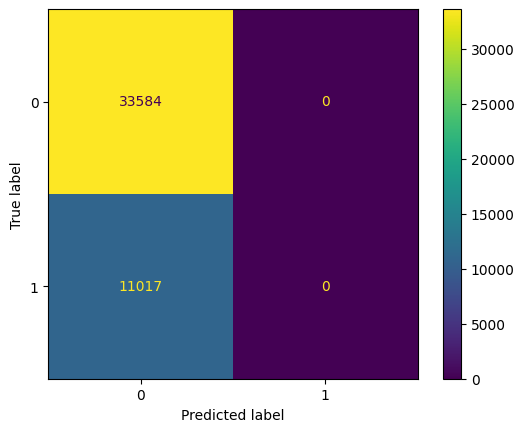

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


acc: 0.9680774438906335/precision: 0.0/recall: 0.0/f1-measure: 0.0


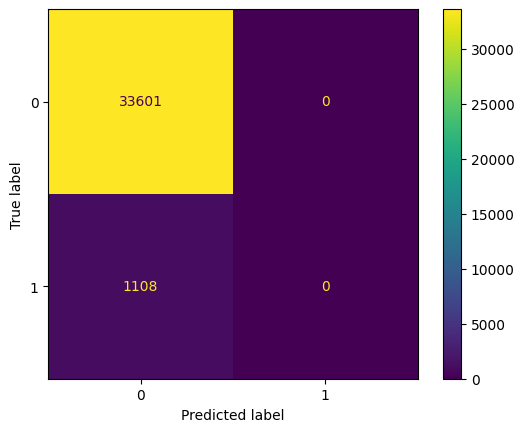

Test standardize Logistic Regressor/Imbalanced Logisitic Regressor
acc: 0.7529427591309612/precision: 0.4642857142857143/recall: 0.0011799945538712897/f1-measure: 0.002354006337709371


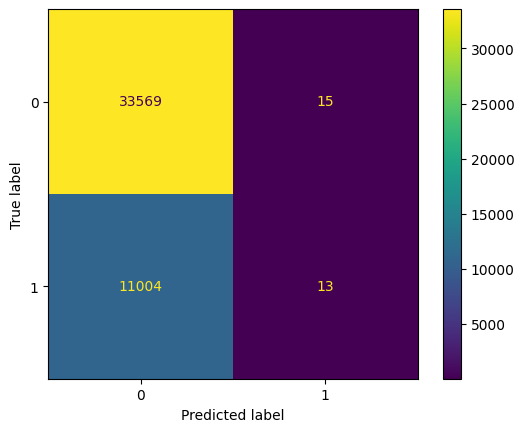

acc: 0.43446944596502346/precision: 0.02894348644386795/recall: 0.5135379061371841/f1-measure: 0.054798478355082586


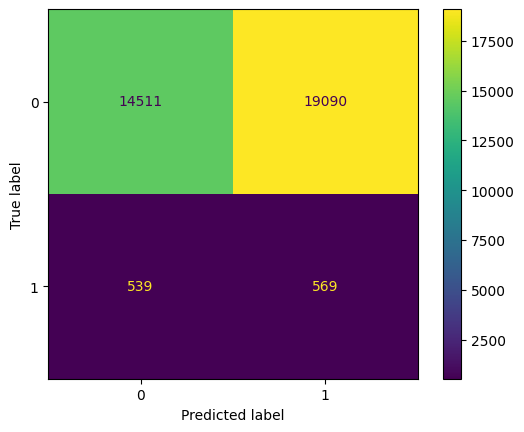

In [8]:
# 모델정의, 정답이 두개니 BinomialLogistic, pytorch
class TorchLogisticRegression(nn.Module):
  def __init__(self, data, num_class):
    super(TorchLogisticRegression, self).__init__()
    # 행렬 곱의 특성 : XW
    # 데이터 : 가지고 있는 데이터의 개수 (row) x 가지고 있는 데이터의 피쳐의 개수 (col)
    self.logistic_regressor = nn.Linear(data.shape[1], num_class) # weight matrix, bias vector

  def forward(self, data): # class의 instance 호출 시 사용되는 부분
    logit = self.logistic_regressor(data)

    return logit

  def get_params(self): # 모델 내 weight matrix와 bias vector 파라미터 확인하기 위한 부분
    torch_weight, torch_bias = self.logistic_regressor.weight.detach().cpu().numpy(), self.logistic_regressor.bias.detach().cpu().numpy()

    return torch_weight, torch_bias

min_max_logistic_regressor = TorchLogisticRegression(min_max_train_data, num_binomial_class).to(device)
min_max_torch_model_optimizer = torch.optim.SGD(min_max_logistic_regressor.parameters(), lr =learning_rate)

imbalanced_min_max_logistic_regressor = TorchLogisticRegression(imbalance_min_max_train_data, num_binomial_class).to(device)
imbalanced_min_max_torch_model_optimizer = torch.optim.SGD(imbalanced_min_max_logistic_regressor.parameters(), lr =learning_rate)

standardize_logistic_regressor = TorchLogisticRegression(standardize_train_data, num_binomial_class).to(device)
standardize_torch_model_optimizer = torch.optim.SGD(standardize_logistic_regressor.parameters(), lr =learning_rate)

imbalanced_standardize_logistic_regressor = TorchLogisticRegression(imbalance_standardize_train_data, num_binomial_class).to(device)
imbalanced_standardize_torch_model_optimizer = torch.optim.SGD(imbalanced_standardize_logistic_regressor.parameters(), lr =learning_rate)

def train_logistic_regressor(data, label, model, criterion, optimizer, epochs, device):
  model.train()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.long).to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()

    result = model(data)

    loss = criterion(result, label)

    loss.backward()
    optimizer.step()


train_logistic_regressor(min_max_train_data, min_max_train_label_data, min_max_logistic_regressor, criterion, min_max_torch_model_optimizer, epochs, device)

train_logistic_regressor(imbalance_min_max_train_data, imbalance_min_max_train_label_data, imbalanced_min_max_logistic_regressor, criterion, imbalanced_min_max_torch_model_optimizer, epochs, device)

train_logistic_regressor(standardize_train_data, standardize_train_label_data, standardize_logistic_regressor, criterion, standardize_torch_model_optimizer, epochs, device)

train_logistic_regressor(imbalance_standardize_train_data, imbalance_standardize_train_label_data, imbalanced_standardize_logistic_regressor, criterion, imbalanced_min_max_torch_model_optimizer, epochs, device)

def test_logistic_regressor(data, label, model, device):
    model.eval()
    data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.long).detach().cpu().numpy()
    with torch.no_grad():
      result = model(data)
      _, result = torch.max(result, 1)
      result = result.detach().cpu().numpy()
      accuracy = accuracy_score(label, result)
      precision = precision_score(label, result)
      recall = recall_score(label, result)
      f1_measure = f1_score(label, result)

    print('acc: {}/precision: {}/recall: {}/f1-measure: {}'.format(accuracy, precision, recall, f1_measure))

    result_confusion_matrix = confusion_matrix(label, result)
    ConfusionMatrixDisplay(result_confusion_matrix, display_labels=[0, 1]).plot()
    plt.show()


print('Logistic Regressor')
print('=========================================================================================')
print('min_max model\n')
test_logistic_regressor(min_max_test_data, min_max_test_label_data, min_max_logistic_regressor, device)

print('=========================================================================================')
print('imbalanced min_max model\n')

test_logistic_regressor(imbalance_min_max_test_data, imbalance_min_max_test_label_data, imbalanced_min_max_logistic_regressor, device)
print('=========================================================================================')
print('standardize model\n')

test_logistic_regressor(standardize_test_data, standardize_test_label_data, standardize_logistic_regressor, device)
print('=========================================================================================')
print('imbalanced standardize model\n')

test_logistic_regressor(imbalance_standardize_test_data, imbalance_standardize_test_label_data, imbalanced_standardize_logistic_regressor, device)

DecisionTree
min-max model

acc: 0.9999775789780498/precision: 0.9999092394263932/recall: 1.0/f1-measure: 0.9999546176537327


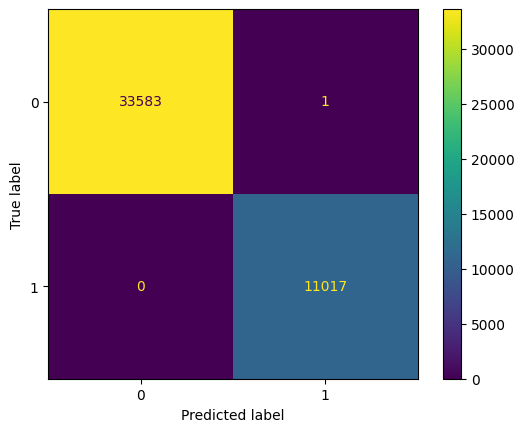

imbalanced min-max model

acc: 0.9999135670863465/precision: 0.9972997299729973/recall: 1.0/f1-measure: 0.9986480396575034


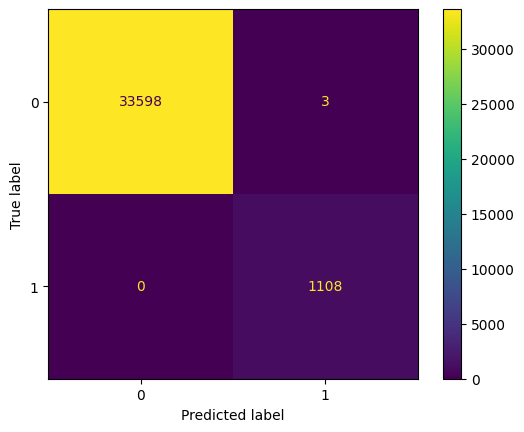

standardize model

acc: 0.9999775789780498/precision: 0.9999092394263932/recall: 1.0/f1-measure: 0.9999546176537327


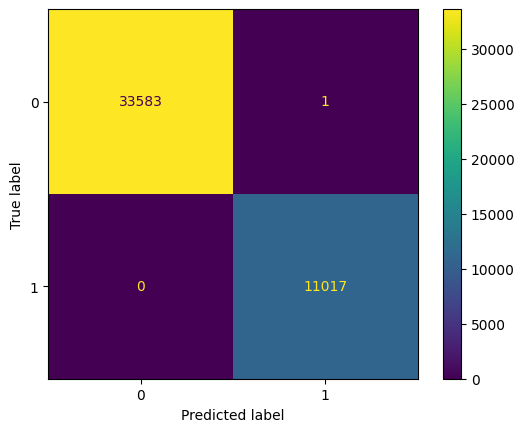

imbalanced standardize model

acc: 0.9999135670863465/precision: 0.9972997299729973/recall: 1.0/f1-measure: 0.9986480396575034


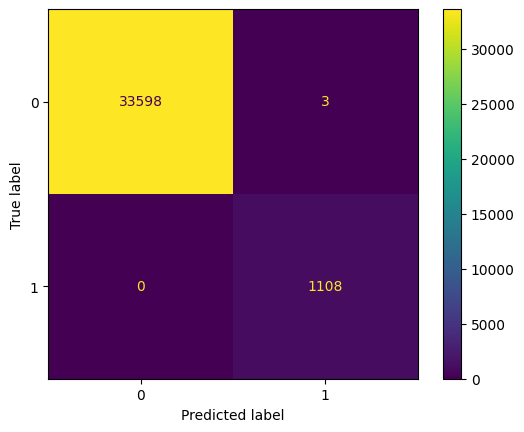

In [10]:
# DecisionTree
class SklearnDecisionTreeClassifier:
    def __init__(self, feature_names, max_depth, min_sample_leaf, random_state):
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.random_state = random_state

        self.classifier = tree.DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_sample_leaf,
            random_state=self.random_state
        )

    def __call__(self, data):
        return self.classifier.predict(data)

    def show_tree(self):
        tree.plot_tree(self.classifier)

    def show_customized_tree(self):
        dot_data = tree.export_graphviz(
            self.classifier,
            out_file=None,
            feature_names=self.feature_names[:-1],
            class_names = ['0', '1'],
            filled=True,
            rounded=True,
            special_characters=True
        )
        graph = graphviz.Source(dot_data)
        graph.view()
    def train_model(self, train_data, train_label):
        self.classifier.fit(train_data, train_label)

    def test_model(model, data, label):
        pred = model.classifier.predict(data)
        accuracy = accuracy_score(label, pred)
        precision = precision_score(label, pred)
        recall = recall_score(label, pred)
        f1_measure = f1_score(label, pred)
        print('acc: {}/precision: {}/recall: {}/f1-measure: {}'.format(accuracy, precision, recall, f1_measure))

        result_confusion_matrix = confusion_matrix(label, pred)
        ConfusionMatrixDisplay(result_confusion_matrix, display_labels=[0, 1]).plot()
        plt.show()

# 모델 학습및 테스트
print('DecisionTree')
print('=========================================================================================')
print('min-max model\n')
min_max_sklearn_dt_classifier = SklearnDecisionTreeClassifier(feature_name, max_depth, min_sample_leaf, random_state)
min_max_sklearn_dt_classifier.train_model(min_max_train_data, min_max_train_label_data)
min_max_sklearn_dt_classifier.test_model(min_max_test_data, min_max_test_label_data)
print('=========================================================================================')
print('imbalanced min-max model\n')
imbalanced_min_max_sklearn_dt_classifier = SklearnDecisionTreeClassifier(feature_name, max_depth, min_sample_leaf, random_state)
imbalanced_min_max_sklearn_dt_classifier.train_model(imbalance_min_max_train_data,imbalance_min_max_train_label_data)
imbalanced_min_max_sklearn_dt_classifier.test_model(imbalance_min_max_test_data, imbalance_min_max_test_label_data)
print('=========================================================================================')
print('standardize model\n')
standardize_sklearn_dt_classifier = SklearnDecisionTreeClassifier(feature_name, max_depth, min_sample_leaf, random_state)
standardize_sklearn_dt_classifier.train_model(standardize_train_data, standardize_train_label_data)
standardize_sklearn_dt_classifier.test_model(standardize_test_data, standardize_test_label_data)
print('=========================================================================================')
print('imbalanced standardize model\n')
imbalanced_standardize_sklearn_dt_classifier = SklearnDecisionTreeClassifier(feature_name, max_depth, min_sample_leaf, random_state)
imbalanced_standardize_sklearn_dt_classifier.train_model(imbalance_standardize_train_data, imbalance_standardize_train_label_data)
imbalanced_standardize_sklearn_dt_classifier.test_model(imbalance_standardize_test_data, imbalance_standardize_test_label_data)

Random Forest
min-max model

acc: 0.9261003116522051/precision: 1.0/recall: 0.7008259961877099/f1-measure: 0.824100757818337


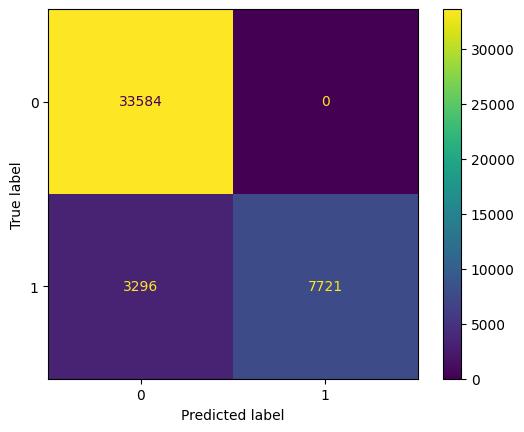

imbalanced min-max model

acc: 0.9261003116522051/precision: 1.0/recall: 0.7008259961877099/f1-measure: 0.824100757818337


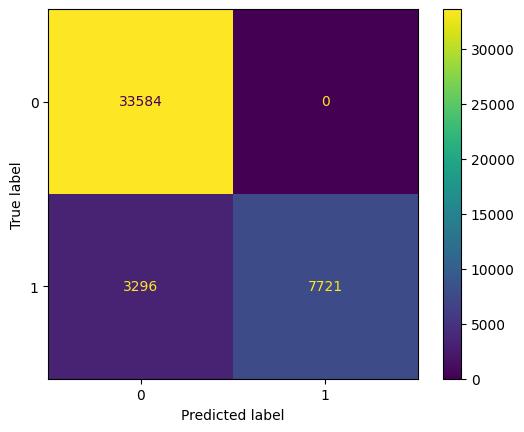

standardize model

acc: 0.9261003116522051/precision: 1.0/recall: 0.7008259961877099/f1-measure: 0.824100757818337


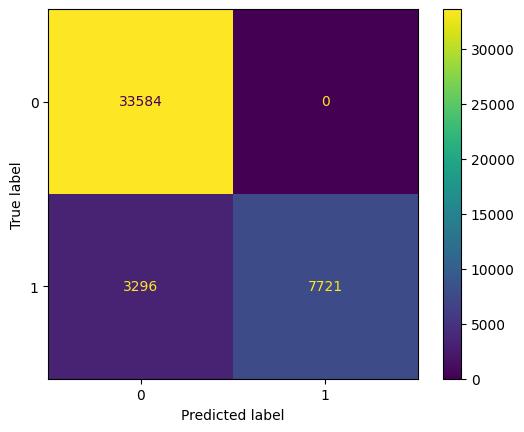

imbalanced standardize model

acc: 0.9815609784205825/precision: 1.0/recall: 0.4223826714801444/f1-measure: 0.5939086294416244


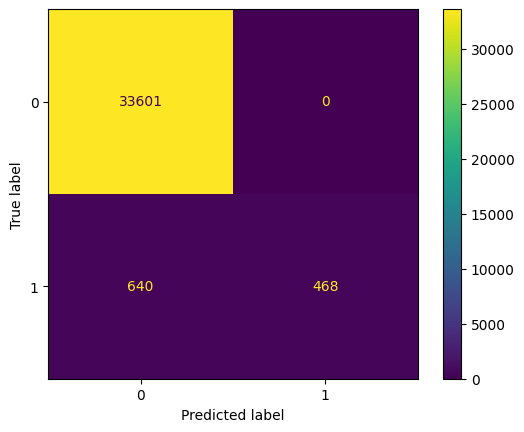

In [18]:
# randowm forest
n_estimators = 100      # 랜덤 포레스트 안의 결정 트리 갯수
class SklearnRandomForestClassifier:
  def __init__(self, n_estimators, max_depth, random_state):
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.random_state = random_state

    self.classifier = ensemble.RandomForestClassifier(
        n_estimators=self.n_estimators,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.classifier.predict(data)

  def train_model(self, train_data, train_label):
    self.classifier.fit(train_data, train_label)

  def test_model(self, test_data, test_label):

    pred = self.classifier.predict(test_data)
    accuracy = accuracy_score(test_label, pred)
    precision = precision_score(test_label, pred)
    recall = recall_score(test_label, pred)
    f1_measure = f1_score(test_label, pred)

    print('acc: {}/precision: {}/recall: {}/f1-measure: {}'.format(accuracy, precision, recall, f1_measure))
    result_confusion_matrix = confusion_matrix(test_label, pred)
    ConfusionMatrixDisplay(result_confusion_matrix, display_labels=[0, 1]).plot()
    plt.show()

print('Random Forest')
print('=========================================================================================')
print('min-max model\n')
min_max_sklearn_rf_classifier = SklearnRandomForestClassifier(n_estimators, max_depth, random_state)
min_max_sklearn_rf_classifier.train_model(min_max_train_data, min_max_train_label_data)
min_max_sklearn_rf_classifier.test_model(min_max_test_data, min_max_test_label_data)
print('=========================================================================================')
print('imbalanced min-max model\n')
imbalanced_min_max_sklearn_rf_classifier = SklearnRandomForestClassifier(n_estimators, max_depth, random_state)
imbalanced_min_max_sklearn_rf_classifier.train_model(min_max_train_data, min_max_train_label_data)
imbalanced_min_max_sklearn_rf_classifier.test_model(min_max_test_data, min_max_test_label_data)
print('=========================================================================================')
print('standardize model\n')
standardize_sklearn_rf_classifier = SklearnRandomForestClassifier(n_estimators, max_depth, random_state)
standardize_sklearn_rf_classifier.train_model(standardize_train_data, standardize_train_label_data)
standardize_sklearn_rf_classifier.test_model(standardize_test_data, standardize_test_label_data)
print('=========================================================================================')
print('imbalanced standardize model\n')
imbalanced_standardize_sklearn_rf_classifier = SklearnRandomForestClassifier(n_estimators, max_depth, random_state)
imbalanced_standardize_sklearn_rf_classifier.train_model(imbalance_standardize_train_data, imbalance_standardize_train_label_data)
imbalanced_standardize_sklearn_rf_classifier.test_model(imbalance_standardize_test_data, imbalance_standardize_test_label_data)

Gradient Boosted Trees for Classifciation
min-max model

acc: 0.9999775789780498
recall: 1.0
precision: 0.9999092394263932
f1: 0.9999546176537327


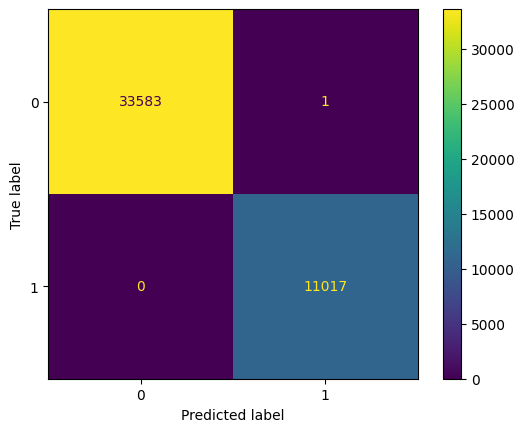

imbalanced min-max model

acc: 0.9999135670863465
recall: 1.0
precision: 0.9972997299729973
f1: 0.9986480396575034


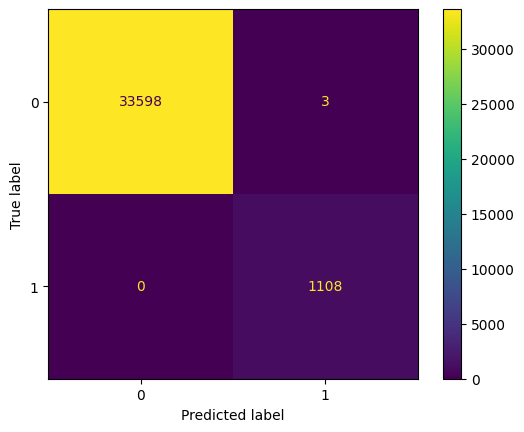

standardize model

acc: 0.9999775789780498
recall: 1.0
precision: 0.9999092394263932
f1: 0.9999546176537327


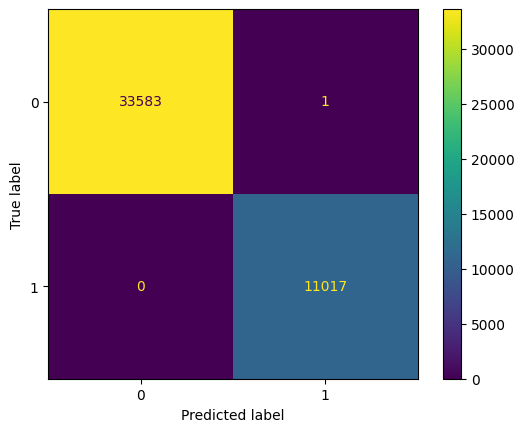

imbalanced standardize model

acc: 0.9999135670863465
recall: 1.0
precision: 0.9972997299729973
f1: 0.9986480396575034


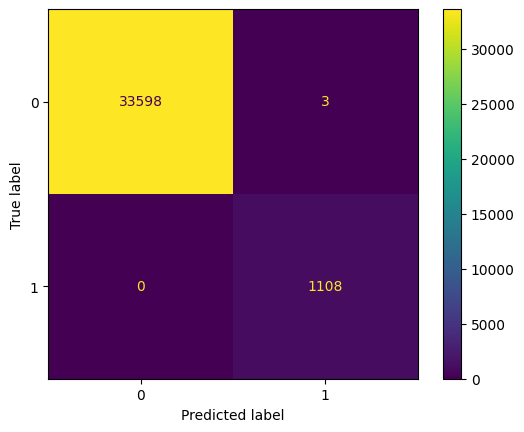

In [17]:
# Scikit Learn 기반 boosting 모델
class SklearnGradientBoostingClassifier:
  def __init__(self, n_estimators, max_depth, random_state):
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.random_state = random_state

    self.classifier = ensemble.GradientBoostingClassifier(
        n_estimators=self.n_estimators,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.classifier.predict(data)

  def train_model(self, train_data, train_label):
      self.classifier.fit(train_data, train_label)

  def test_model(self, test_data, test_label):
    pred = self.classifier.predict(test_data)

    accuracy = accuracy_score(test_label, pred)
    recall = recall_score(test_label, pred)
    precision = precision_score(test_label, pred)
    f1 = f1_score(test_label, pred)

    print('acc: {}'.format(accuracy))
    print('recall: {}'.format(recall))
    print('precision: {}'.format(precision))
    print('f1: {}'.format(f1))
    result_confusion_matrix = confusion_matrix(test_label, pred)
    ConfusionMatrixDisplay(result_confusion_matrix, display_labels=[0, 1]).plot()
    plt.show()

print('Gradient Boosted Trees for Classifciation')
print('=========================================================================================')
print('min-max model\n')
min_max_sklearn_gbdt_classifier= SklearnGradientBoostingClassifier(n_estimators, max_depth, random_state)
min_max_sklearn_gbdt_classifier.train_model(min_max_train_data, min_max_train_label_data)
min_max_sklearn_gbdt_classifier.test_model(min_max_test_data, min_max_test_label_data)
print('=========================================================================================')
print('imbalanced min-max model\n')
imbalance_min_max_sklearn_gbdt_classifier= SklearnGradientBoostingClassifier(n_estimators, max_depth, random_state)
imbalance_min_max_sklearn_gbdt_classifier.train_model(imbalance_min_max_train_data, imbalance_min_max_train_label_data)
imbalance_min_max_sklearn_gbdt_classifier.test_model(imbalance_min_max_test_data, imbalance_min_max_test_label_data)
print('=========================================================================================')
print('standardize model\n')
standardize_sklearn_gbdt_classifier= SklearnGradientBoostingClassifier(n_estimators, max_depth, random_state)
standardize_sklearn_gbdt_classifier.train_model(standardize_train_data, standardize_train_label_data)
standardize_sklearn_gbdt_classifier.test_model(standardize_test_data, standardize_test_label_data)
print('=========================================================================================')
print('imbalanced standardize model\n')
imbalance_standardize_sklearn_gbdt_classifier= SklearnGradientBoostingClassifier(n_estimators, max_depth, random_state)
imbalance_standardize_sklearn_gbdt_classifier.train_model(imbalance_standardize_train_data, imbalance_standardize_train_label_data)
imbalance_standardize_sklearn_gbdt_classifier.test_model(imbalance_standardize_test_data, imbalance_standardize_test_label_data)

XGBoost for Classification
min-max model

acc: 0.9999775789780498
recall: 1.0
precision: 0.9999092394263932
f1: 0.9999546176537327


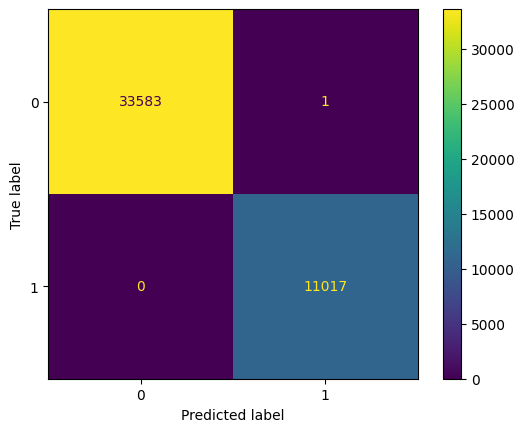

imbalanced min-max model

acc: 0.9999711890287821
recall: 1.0
precision: 0.9990982867448152
f1: 0.9995489400090212


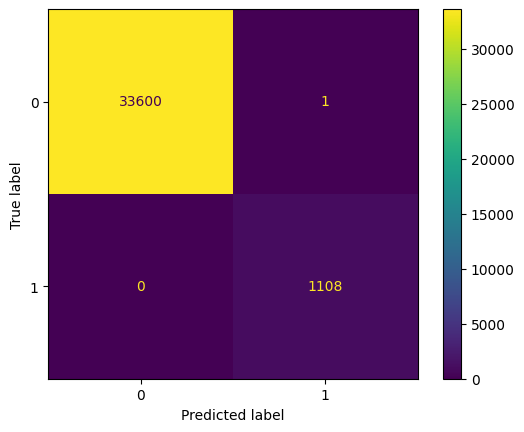

standardize model

acc: 0.9999775789780498
recall: 1.0
precision: 0.9999092394263932
f1: 0.9999546176537327


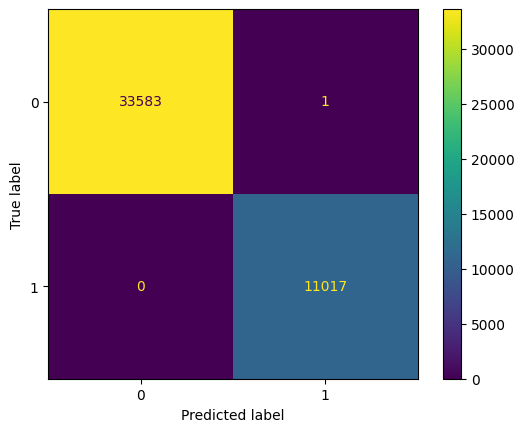

imbalanced standardize model

acc: 0.9999711890287821
recall: 1.0
precision: 0.9990982867448152
f1: 0.9995489400090212


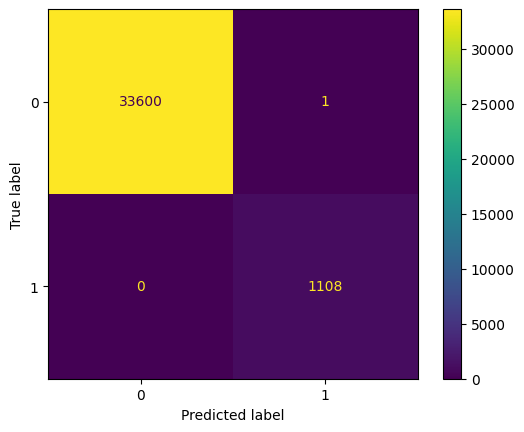

In [16]:
# XGBoost 기반 boosting 모델
import xgboost

class XGBoostClassifier:
  def __init__(self, random_state):
    self.random_state = random_state

    self.classifier = xgboost.XGBClassifier(
      objective='binary:logistic',
      eval_metric='logloss',
      random_state=self.random_state
    )

  def __call__(self, data):
    return self.classifier.predict(data)

  def train_model(self, train_data, train_label):
      self.classifier.fit(train_data, train_label)

  def test_model(self, test_data, test_label):
    pred = self.classifier.predict(test_data)
    accuracy = accuracy_score(test_label, pred)
    recall = recall_score(test_label, pred)
    precision = precision_score(test_label, pred)
    f1 = f1_score(test_label, pred)

    print('acc: {}'.format(accuracy))
    print('recall: {}'.format(recall))
    print('precision: {}'.format(precision))
    print('f1: {}'.format(f1))
    result_confusion_matrix = confusion_matrix(test_label, pred)
    ConfusionMatrixDisplay(result_confusion_matrix, display_labels=[0, 1]).plot()
    plt.show()


print('XGBoost for Classification')
print('=========================================================================================')
print('min-max model\n')
min_max_xgboost_classifier = XGBoostClassifier(random_state)
min_max_xgboost_classifier.train_model(min_max_train_data, min_max_train_label_data)
min_max_xgboost_classifier.test_model(min_max_test_data, min_max_test_label_data)

print('=========================================================================================')
print('imbalanced min-max model\n')
imbalance_xgboost_classifier = XGBoostClassifier(random_state)
imbalance_xgboost_classifier.train_model(imbalance_min_max_train_data, imbalance_min_max_train_label_data)
imbalance_xgboost_classifier.test_model(imbalance_min_max_test_data, imbalance_min_max_test_label_data)

print('=========================================================================================')
print('standardize model\n')
standardize_xgboost_classifier = XGBoostClassifier(random_state)
standardize_xgboost_classifier.train_model(standardize_train_data, standardize_train_label_data)
standardize_xgboost_classifier.test_model(standardize_test_data, standardize_test_label_data)

print('=========================================================================================')
print('imbalanced standardize model\n')
imbalanced_standardize_xgboost_classifier = XGBoostClassifier(random_state)
imbalanced_standardize_xgboost_classifier.train_model(imbalance_standardize_train_data, imbalance_standardize_train_label_data)
imbalanced_standardize_xgboost_classifier.test_model(imbalance_standardize_test_data, imbalance_standardize_test_label_data)